In [1]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy


In [2]:
## load the kiva_loans.csv. display info and head
df = pd.read_csv('Data/insurance - insurance.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Q1: Do smokers have higher insurance charges than non-smokers?

## 1. State the Hypothesis & Null Hypothesis

 Ho (Null Hypothesis):Everyone has the same insurance charges regardless if they smoke.
 
 Ha (Alternative Hypothesis): Those that smoke have higher insurance charges than those that don't smoke 

## 2. Determine the correct test to perform.

Type of Data? Numeric

How many groups/samples? 2 groups

Therefore, which test is appropriate? 2 sample T test

In [3]:
# creating a df with only the columns that I am interested in 
df1 = df[['smoker','charges']]
df1.head()

,smoker,charges
0,yes,16884.92400
1,no,1725.55230
2,no,4449.46200
3,no,21984.47061
4,no,3866.85520


In [4]:
# creating a group that has a discount and showing the counts

df1['is_smoker'] = df1['smoker'] == 'yes'
df1['is_smoker'].value_counts()

C:\Users\dvisi\AppData\Local\Temp\ipykernel_31792\2625224084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['is_smoker'] = df1['smoker'] == 'yes'


False    1064
True      274
Name: is_smoker, dtype: int64

In [5]:
## save list of columns needed for each group
needed_cols = ['charges','is_smoker']
df1[needed_cols]

,charges,is_smoker
0,16884.92400,True
1,1725.55230,False
2,4449.46200,False
3,21984.47061,False
4,3866.85520,False
...,...,...
1333,10600.54830,False
1334,2205.98080,False
1335,1629.83350,False
1336,2007.94500,False


In [6]:
# creating a non smoker df from non smoker group
non_df = df1.loc[df1['is_smoker']==False, needed_cols]
non_df

,charges,is_smoker
1,1725.55230,False
2,4449.46200,False
3,21984.47061,False
4,3866.85520,False
5,3756.62160,False
...,...,...
1332,11411.68500,False
1333,10600.54830,False
1334,2205.98080,False
1335,1629.83350,False


In [7]:
# creating a is smoker df 
smoke_df = df1.loc[df1['is_smoker']==True, needed_cols]
smoke_df

,charges,is_smoker
0,16884.92400,True
11,27808.72510,True
14,39611.75770,True
19,36837.46700,True
23,37701.87680,True
...,...,...
1313,36397.57600,True
1314,18765.87545,True
1321,28101.33305,True
1323,43896.37630,True


## Testing Assumptions

### No significant Outliers

In [8]:
## Saving the numeric col as final group variables

smoker = smoke_df['charges']
non_smoker = non_df['charges']

smoker

0       16884.92400
11      27808.72510
14      39611.75770
19      36837.46700
23      37701.87680
           ...     
1313    36397.57600
1314    18765.87545
1321    28101.33305
1323    43896.37630
1337    29141.36030
Name: charges, Length: 274, dtype: float64

In [9]:
# checking for outliers in smoker group

smoke_outliers = np.abs(stats.zscore(smoker)) > 3

# how many outliers in the has discounts group

smoke_outliers.value_counts()

False    274
Name: charges, dtype: int64

In [10]:
# checking for outliers in smoker group

non_smoke_outliers = np.abs(stats.zscore(non_smoker)) > 3

# how many outliers in the has discounts group

non_smoke_outliers.value_counts()

False    1040
True       24
Name: charges, dtype: int64

In [11]:
# removing the outliers for the non smoking group
non_smoker = non_smoker[~non_smoke_outliers]
non_smoker

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1040, dtype: float64

### Normality

According to the lesson plan, since both groups have n> 15, it is possible to safely ignore the assumption of normality. For that reason I will not be checking the normality of either group.

In [12]:
## Use Levene's test for equal variance
result= stats.levene(smoker, non_smoker)
print(result)
result.pvalue <0.05

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


True

SUMMARY OF ASSUMPTIONS OBSERVATIONS:

The non smoking group had outliers which I was able to remove. For Normality i was able to ignore the test since both groups have more than 15 samples. Finally when looking for equal variance I found that the groups do NOT have equal variance. Because that assumption is not met, I will have to run the ttest using the equal_var=False. This will run the Welch's T-Test which takes into account groups of unequal variance.

In [13]:
result = stats.ttest_ind(smoker, non_smoker, equal_var=False)
print(result)

result.pvalue < 0.05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


True

## Conclusion

The Welch's T-Test returned a p-value that was less then the chosen alpha of 5%. Because of this the null hypothesis can be rejected. This supports the alternative hypothesis that states:

Those that smoke have higher insurance charges than those that don't smoke

In [15]:
# printing the averages for both groups

print(f"The average amount of charges that smokers were billed is {round(smoker.mean(), 2)}")
print(f"The average amount of charges that non-smokers were billed is {round(non_smoker.mean(), 2)}")

The average amount of charges that smokers were billed is 32050.23
The average amount of charges that non-smokers were billed is 7939.86


In [17]:
# creating the plot data in order to visuialize the information

plot_df = pd.concat([non_df.loc[~non_smoke_outliers], smoke_df.loc[~smoke_outliers]], axis=0)
plot_df

,charges,is_smoker
1,1725.55230,False
2,4449.46200,False
3,21984.47061,False
4,3866.85520,False
5,3756.62160,False
...,...,...
1313,36397.57600,True
1314,18765.87545,True
1321,28101.33305,True
1323,43896.37630,True


<AxesSubplot:xlabel='is_smoker', ylabel='charges'>

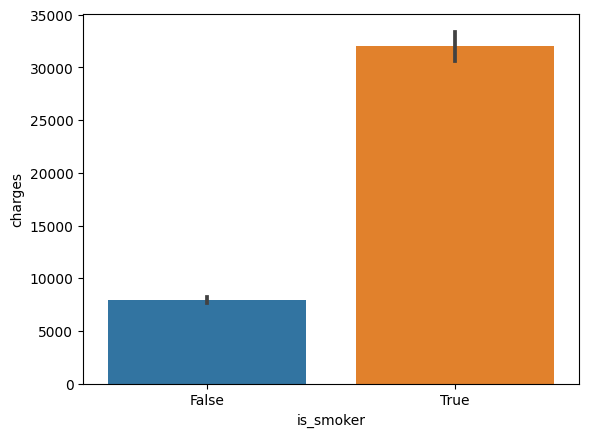

In [19]:
# creating the bar plot to show difference in means of both groups

sns.barplot(data=plot_df, x='is_smoker', y='charges')

# Q2: Are men more likely to smoke than women?

## 1. State the Hypothesis & Null Hypothesis

 Ho (Null Hypothesis): Both men and women are equably as likely to smoke.
 
 Ha (Alternative Hypothesis): Men are more likely to smoke than women. 

## 2. Determine the correct test to perform.

Type of Data? Categorical 

How many groups/samples? 2 groups

Therefore, which test is appropriate? Chi-Square



In [24]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table


smoker,no,yes
sex,,
female,547,115
male,517,159


In [25]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results



In [26]:
# What was our p-value?
print(p)
p<.05



0.006548143503580696


True

## Conclusion

The Chi-Squared Test returned a p-value that was less then the chosen alpha of 5%. Because of this the null hypothesis can be rejected. This supports the alternative hypothesis that states:

Men are more likely to smoke than women. 

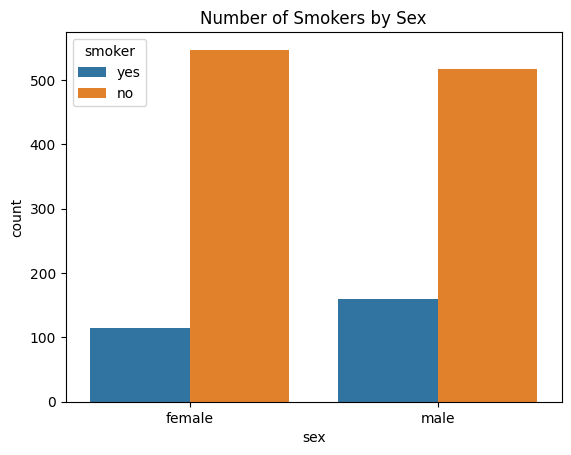

In [23]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");


# Q3: Do different regions have different charges, on average?

## 1. State the Hypothesis & Null Hypothesis

 Ho (Null Hypothesis): On average all regions have similar charges.
 
 Ha (Alternative Hypothesis): There is a big difference in charges based on which region a person is located.

## 2. Determine the correct test to perform.

Type of Data? Numerical

How many groups/samples? 4 groups

Therefore, which test is appropriate? One way ANOVA

In [27]:
# creating a df with only the columns that I am interested in 
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [29]:
# Create groups dictionary for the 4 groups
groups = {}
# using the loop from the lesson plan in order to get all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()



dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [30]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


### Normality

According to the lesson plan, since all groups have n> 15, it is possible to safely ignore the assumption of normality. For that reason I will not be checking the normality of either group.


In [32]:
# with the * operator 
stats.levene(*groups.values())


LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

The p value is less than alpha thus the data does not meet equal variance assumption. Will have to use alternate test. Kruskal-Wallis non-parametric test will be used instead of one way ANOVA. 

In [33]:
# performing KW test 
result = stats.kruskal(*groups.values())
result

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

## Conclusion

The Kruskal-Wallis Test returned a p-value that was greater than the chosen alpha of 5%. This means that there is a failure to reject the null hypothesis.



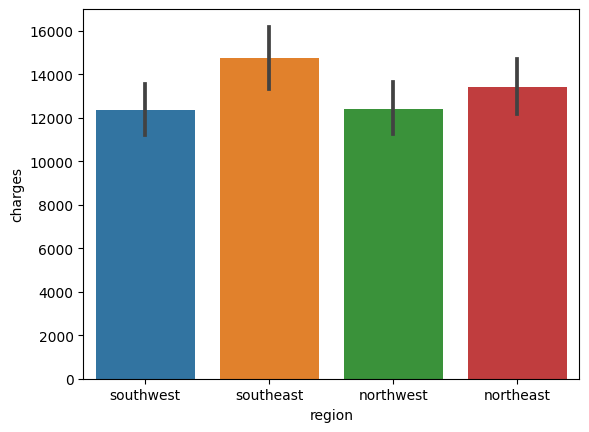

In [35]:
# visualization of region data
sns.barplot(data=df, x='region', y='charges');